## Implementing Random Forest

## Introduction

Random forests and boosting are ensemble methods used for classification and regression, but in this particular case I'll be focusing on classification. Random forests are essentially a collection of decision trees that are each fit on a subsample of the data. While an individual tree is typically noisey and subject to high variance, random forests average many different trees to reduce the variability and leave us with a powerful classifier. 

Random forests are also non-parametric and require little to no parameter tuning. They differ from many common machine learning models used today that are typically optimized using gradient descent. Models like linear regression, support vector machines, neural networks, etc. require a lot of matrix based operations, while on the other hand tree based models like random forest are constructed with just basic arithmetic. In other words, to build a tree all we're really doing is selecting a hand full of observations and features from our dataset and finding the value that makes the best split. We'll define what what it means to be the "best split" in a bit..


## Decision trees

A quick overview if you're not familiar with binary decision trees. We start from very top, which is called the *root node* and ask a simple question. If the answer to the question is correct we'll move to the left node directly connected below, otherwise if wrong we'll move down to the right node. We'll repeat this process until we reach one of the bottom nodes, which are called the *terminal nodes*. For classification the terminal nodes output the class that is the mode while in the context of regression they'll output the mean prediction. The problem with this method of finding the best split point is that it is a rather greedy approach and is subject to high variance when trees aren't pruned. Pruning is essentially the process of trimming off nodes that output little predictive power to reduce overfitting, however, random forests don't require pruning for simplicity and account for overfitting through other techniques like bootstrapping and bagging which we'll soon cover.

![alt text](Data/Images/decision-tree.png)

## The Data

In this particular example I'll be using [Kaggles Titanic](https://www.kaggle.com/c/titanic) dataest. This dataset is incredibly simple and will be useful for demonstrating how the model works in its entirety. 

In [1]:
import random
import pandas as pd
import numpy as np

df = pd.read_csv('Data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The datast consists of simple attributes for each passenger like their age, sex, social class, # of family members, and where they embarked. The objective is for us to predict whether a passenger survived the titanic crash or not where 1 denotes that the passenger survived and 0 denotes that they perished

Something important to note is that random forests don't handle missing values. This requires us to have make some preprocessing steps before training the model, for simplicity I will just be replacing missing values with the avarage or mode. I'm not going to dwell on the details of this dataset so if you're interested in learning more about it I would highly recammend looking over kernels within the competition.

In [2]:
df.loc[df['Age'].isnull(),'Age'] = np.round(df['Age'].mean())
df.loc[df['Embarked'].isnull(),'Embarked'] = df['Embarked'].value_counts().index[0]

In this example I'm going to be using the 7 features: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked

Lets split the data into a training and testing set so we can validate our models performance

In [3]:
features = ['Pclass','Sex','Age','SibSp','Parch', 'Fare', 'Embarked']
nb_train = int(np.floor(0.9 * len(df)))
df = df.sample(frac=1, random_state=217)
X_train = df[features][:nb_train]
y_train = df['Survived'][:nb_train].values
X_test = df[features][nb_train:]
y_test = df['Survived'][nb_train:].values

## Entropy
The most commonly used measurements for constructing binary decision trees are: Entropy, Classification Error, and Gini index. In this thread we'll be focusing on **entropy**, which a measurement of *impurity* (uncertainty) that uses the following formula

$$H(X) = -\sum_{j}p_j\log p_j$$
such that $p_j$ is the probability of class $j$. In the case of binary classification entropy takes on the form

$$H(X) = -p\log_2p-(1-p)\log_2(1-p)$$ 

where $p$ denotes $P(X=1)$ (the probablity that a passenger survived). Also note that in the case of binary classification we use $\log_2$

In [8]:
def entropy(p):
    if p == 0:
        return 0
    elif p == 1:
        return 0
    else:
        return - (p * np.log2(p) + (1 - p) * np.log2(1-p))

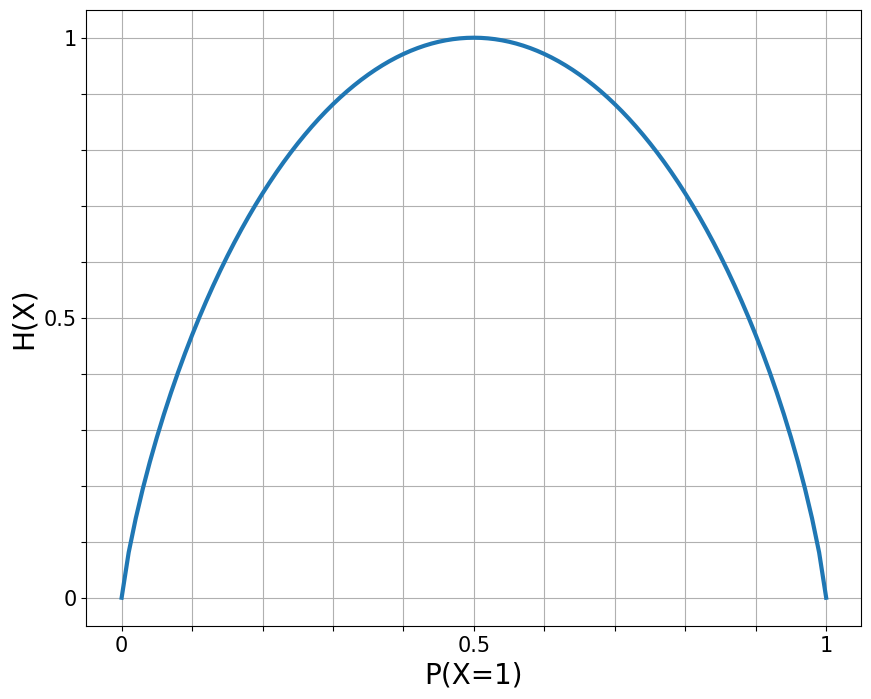

In [9]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

x = np.arange(0.0, 1.01, 0.01)
y = [entropy(p) if p != 0 else 0 for p in x]

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xticklabels([0,'', '', '','', 0.5, '','','','',1],)
ax.set_yticklabels([0,'', '', '','', 0.5, '','','','',1])
plt.plot(x,y,linewidth=3);
ax.grid()
plt.xlabel('P(X=1)', fontsize=20);
plt.ylabel('H(X)', fontsize=20);

Entropy follows a very intuitive interpretation with the following properties:
- **Certainty:** Entropy is minimized when all samples in a node belong to the same class such that $P(X=1)$ = 1 (in our case every passenger survives)
    - $-1\log_2(1) - 0\log_2(0) = 0$
    
    
- **Uncertainty:** Entropy is maximized when we a uniform class ditrubution such that $P(X=1)$ = 0.5 (in our case each passenger has a 50% chance of surviving)
    - $-0.5\log_2(0.5) - 0.5\log_2(0.5) = 0.5 + 0.5 = 1$
    
When we are looking for a training set to split we'll want to find a set that maximizes entropy such that half the passengers survive and half perish, so we'll want to start uncertain. When we are looking for a value to split we'll want to minimize entropy, so we'll want to end as certain as possible. I'll go into further details on this in a bit. 

## Information Gain

When we compare the entropy from before and after a split we get whats called **information gain**. Information gain  measures how much information we gained when splitting a node at a particular value. Information gain $IG$ is computed with the following formula, 

$$IG(D)=I(D_p)-\frac{N_{left}}{N_p}I(D_{left})-\frac{N_{right}}{N_p}I(D_{right})$$ 

where $D_p, D_{left}, D_{right}$ represent the datasets from the parent, left, and right children nodes and $I(D)$ denotes the entropy for that node. This formula can be intrepreted as

$$\text{information gain} = \text{entropy}_{\text{before}} - \text{entropy}_{\text{after}}$$


where $\text{entropy}_{\text{before}}$ is a measure of how uncertain we were with our data **before** we made the split and $\text{entropy}_{\text{after}}$ is a measure for how uncertain we are **after** we split the data. We'll always want to split a node with the value that maximizes information gain. 

To make things a bit more concrete consider the following tree stump:

<img src="Data/Images/sample-node.png" width="600">

Where the parent node has 80 total passengers, 50 survived, and 30 perished. All passengers 18 years old or younger drop into the left child (35 survived, 10 perished) and all passengers older than 18 drop into the right child (15 survived, 20 perished). If we compute the entropy for the parent and both children nodes we'll have the following:
     
$$I(D_p) = -\frac{30}{80}\log_2(\frac{30}{80})-\frac{50}{80}\log_2(\frac{50}{80}) = 0.95$$

$$I(D_{left}) = -\frac{25}{35}\log_2(\frac{25}{35})-\frac{10}{35}\log_2(\frac{10}{35}) = 0.86$$

$$I(D_{right}) = -\frac{5}{45}\log_2(\frac{5}{45})-\frac{40}{45}\log_2(\frac{40}{45}) = 0.50$$

which will give us the following information gain, 

$$I(D) = 0.95 - \frac{35}{80}(0.86)-\frac{45}{80}(0.50) = 0.292$$

If this is the largest information gain among all the possible splits we would use this value as the chosen split point on this particular node. We'll repeat this process for each node until we've reached a terminal node that only consists of one class only *or* when we reach the maximum depth specified beforehand. The class with the highest counts in a terminal node (sometimes reffered to as a leaf) will be assigned to any test value that lands on that terminal. 

Now that we know how to construct a single tree lets go over the method for building a random forest..

## Bootstrapping

One of the main reasons random forests are a powerul machine learning model is the idea behind injecting randomness into each tree. What do I mean by this? 
Each individual decision tree will be constructed on a bootstrapped subset of our data. If our dataset has $n$ observations **bootstrapping** is the process of sampling $n$ points **with** replacement. We can actually calculate that the probability an observation is omitted from our bootstrapped dataset is  $(1 - \frac{1}{n})^{n}$. By definition $e^{-1} = \displaystyle \lim_{n\to\infty}(1-\frac{1}{n})^n$ and since $e^{-1}$ = 0.36787.. $\approx \frac{1}{3}$ $\Rightarrow$ bootstrapping $n$ samples with replacement will leave out approximately $\frac{1}{3}$ of the observations in each distinct tree. Since each individual tree is built using only $\frac{2}{3}$ of the data we'll  find that most trees will differ from one another. If interested a full proof of this can be found on my blog [here](carbonati.github.io/misc/random-forest-oob-sample-size)

The other great thing that comes with bootstrapping is that we get whats called an **Out of Bag Error estimate** for free. The OOB (out of bag) samples are the $\approx \frac{1}{3}$ observations that were not selected to build a parcticular tree. After we've built our tree with the *n* bootstrapped observations we can test each $\vec{x}_i$ that was left out and compute the mean prediction error for all the OOB samples, which we can record as the trees OOB score. Taking the mean of all the OOB scores give us our random forests OOB error, this is essentially **leave-one-out cross validation**. This ultimately tells us how accurate our model is without having to formally test it and we'll soon find that it is approximately the same error rate we'll get at test time.

## Bagging

The other great idea that random forests introduce is the concept of bagging. **Bagging** relies on one parameter, the number of trees to build. Each decision tree is grown such that at each node in the tree looks at **every** value in our bootstrapped sample in **every** feature to find the best split in the data at that particular node.

Random forests follow the same procedure as bagging, however, the key difference is that on a dataset with $p$ features each tree will only look at a **subset of features** $m$ where $m=\sqrt(p)$. This is injecting even more randomness into the model due to the fact that if we sampled all $p$ features in each tree we would likely be making splits at the same values from the same features in most trees. Given that we are only looking at $\sqrt(p)$ features at once many of the trees will be looking at a different groups of feature. With this we'll be able to produce many *uncorrelated* trees which will help us capture a lot of the variability as well as interactions between multiple variables.

## Random Forest algorithm

Suppose we have the following data data {$(\vec{x}_1,y_1),(\vec{x}_2,y_2),..,(\vec{x}_n,y_n)$} where each $\vec{x}_i$ represents a feature vector $[x_{i1},x_{i2},...,x_{im}]$ and let $B$ be the number of trees we want to construct in our forest. We will do the following,

1. for $b=1$ to $B$:
    1. Draw a bootstrap sample of size *n* from the data
    
    2. Grow a decision tree $T_b$ from our bootstrapped sample, by repeating the following steps until the each node consists of 1 class only or until we've reached the minimum node size $\min_{size}$ specified beforehand 
        
         i. sample $m=\sqrt{p}$ features (where $p$ is the number of features in our dataset)
      
        ii. compute the information gain for each possible value among the bootstrapped data and $m$ features
      
        iii. split the into 2 children nodes

2. Output the ensemble of trees $\{T\}^B_1$


## Show me the code

Now that we understand how to construct an individual decision tree and all the necessary steps to build our random forest lets write it all from scratch

Lets first define ```entropy``` and ```information_gain``` which we will help us in finding the best split point

In [10]:

    
def information_gain(left_child, right_child):
    parent = left_child + right_child
    p_parent = parent.count(1) / len(parent) if len(parent) > 0 else 0
    p_left = left_child.count(1) / len(left_child) if len(left_child) > 0 else 0
    p_right = right_child.count(1) / len(right_child) if len(right_child) > 0 else 0
    IG_p = entropy(p_parent)
    IG_l = entropy(p_left)
    IG_r = entropy(p_right)
    return IG_p - len(left_child) / len(parent) * IG_l - len(right_child) / len(parent) * IG_r


where ```entropy``` takes in a probability of a class within a node and ```information_gain``` takes in a list of the classes from the left and right child and returns the information gain of that particular split. 

Lets also define a ```draw_bootstrap``` function that can take in the training input $X$ in the form of a dataframe and also the output $y$ in the form of an array. We'll have it return the bootstrap sampled $X_{boot}$ and $y_{boot}$ that we'll use to construct a tree. We'll also return the out of bag observations that were left out for training which we'll call ```X_oob``` and ```y_oob```. At each new iteration we'll use the OOB samples to evaluate the performance of the tree built with the bootstrapped data. So in other words if we have 100 trees we'll have 100 OOB scores

In [11]:
def draw_bootstrap(X_train, y_train):
    bootstrap_indices = list(np.random.choice(range(len(X_train)), len(X_train), replace = True))
    oob_indices = [i for i in range(len(X_train)) if i not in bootstrap_indices]
    X_bootstrap = X_train.iloc[bootstrap_indices].values
    y_bootstrap = y_train[bootstrap_indices]
    X_oob = X_train.iloc[oob_indices].values
    y_oob = y_train[oob_indices]
    return X_bootstrap, y_bootstrap, X_oob, y_oob

def oob_score(tree, X_test, y_test):
    mis_label = 0
    for i in range(len(X_test)):
        pred = predict_tree(tree, X_test[i])
        if pred != y_test[i]:
            mis_label += 1
    return mis_label / len(X_test)
        

Next we'll define ```find_split_point``` which does the following:
1. select $m$ features at random
2. for each feature selected iterate through each value in the bootstrapped dataset and compute the information gain
3. Return a dictionary which will represent a node within a tree that contains:

    - the feature index 
    
    - the value to split at 
    
    - left child node
    
    - right child node

 produced from the split point with the **highest** information gain. It's important to note that each child node will be stored as a dictionary with the input $X_{boot}$ as ```X_bootstrap``` and outputs $y_{boot}$ as ```y_bootstrap```

In [12]:
def find_split_point(X_bootstrap, y_bootstrap, max_features):
    feature_ls = list()
    num_features = len(X_bootstrap[0])
    
    while len(feature_ls) <= max_features:
        feature_idx = random.sample(range(num_features), 1)
        if feature_idx not in feature_ls:
            feature_ls.extend(feature_idx)
    
    best_info_gain = -999
    node = None
    for feature_idx in feature_ls:
        for split_point in X_bootstrap[:,feature_idx]:
            left_child = {'X_bootstrap': [], 'y_bootstrap': []}
            right_child = {'X_bootstrap': [], 'y_bootstrap': []}
            
            # split children for continuous variables
            if type(split_point) in [int, float]:
                for i, value in enumerate(X_bootstrap[:,feature_idx]):
                    if value <= split_point:
                        left_child['X_bootstrap'].append(X_bootstrap[i])
                        left_child['y_bootstrap'].append(y_bootstrap[i])
                    else:
                        right_child['X_bootstrap'].append(X_bootstrap[i])
                        right_child['y_bootstrap'].append(y_bootstrap[i])
            # split children for categoric variables
            else:
                for i, value in enumerate(X_bootstrap[:,feature_idx]):
                    if value == split_point:
                        left_child['X_bootstrap'].append(X_bootstrap[i])
                        left_child['y_bootstrap'].append(y_bootstrap[i])
                    else:
                        right_child['X_bootstrap'].append(X_bootstrap[i])
                        right_child['y_bootstrap'].append(y_bootstrap[i])
            
            split_info_gain = information_gain(left_child['y_bootstrap'], right_child['y_bootstrap'])
            if split_info_gain > best_info_gain:
                best_info_gain = split_info_gain
                left_child['X_bootstrap'] = np.array(left_child['X_bootstrap'])
                right_child['X_bootstrap'] = np.array(right_child['X_bootstrap'])
                node = {'information_gain': split_info_gain, 
                        'left_child': left_child, 
                        'right_child': right_child, 
                        'split_point': split_point,
                        'feature_idx': feature_idx}
                
    
    return node

We'll next need a function that decides when to stop splitting nodes in a tree and finally output a terminal node (whether the passengers survives or perishes). On a single tree ```split_node``` works as follows:

   1. Given a node, store the left and right children as ```left_child``` & ```right_child``` and remove them from the original dictionary
   2. Check if either children has 0 observations in them. If one of the children is entirely empty this ultimately means that the best split in the data for that node was unable to differentiate the 2 classes and its best to call ```terminal_node``` and return the tree. ```terminal_node``` returns the class with the highest counts at the current node. 
   3. Check if the current depth of the tree has reached the maximum depth. If so, create a terminal node and return the tree
   4. Check if number of observations in the left child at the current node is less than the minimum samples needed to make a split which will be stored as ```min_samples_split```. If so create a terminal node and return the tree
   5. If the left has more observations than ```min_samples_split``` we'll feed the current node into ```find_split_point``` again to find the best split point and repeat steps 1 - 6. This is ultimately going to be nesting dictionaries, which we are using to represent a node in our tree.
   6. Repeat steps 4 and 5 for the right child node 
   7. Repeat steps 1 - 6 until each branch has a terminal node

In [13]:
def terminal_node(node):
    y_bootstrap = node['y_bootstrap']
    pred = max(y_bootstrap, key = y_bootstrap.count)
    return pred


def split_node(node, max_features, min_samples_split, max_depth, depth):
    left_child = node['left_child']
    right_child = node['right_child']    

    del(node['left_child'])
    del(node['right_child'])
    
    if len(left_child['y_bootstrap']) == 0 or len(right_child['y_bootstrap']) == 0:
        empty_child = {'y_bootstrap': left_child['y_bootstrap'] + right_child['y_bootstrap']}
        node['left_split'] = terminal_node(empty_child)
        node['right_split'] = terminal_node(empty_child)
        return
    
    if depth >= max_depth:
        node['left_split'] = terminal_node(left_child)
        node['right_split'] = terminal_node(right_child)
        return node
    
    if len(left_child['X_bootstrap']) <= min_samples_split:
        node['left_split'] = node['right_split'] = terminal_node(left_child)
    else:
        node['left_split'] = find_split_point(left_child['X_bootstrap'], left_child['y_bootstrap'], max_features)
        split_node(node['left_split'], max_depth, min_samples_split, max_depth, depth + 1)
    if len(right_child['X_bootstrap']) <= min_samples_split:
        node['right_split'] = node['left_split'] = terminal_node(right_child)
    else:
        node['right_split'] = find_split_point(right_child['X_bootstrap'], right_child['y_bootstrap'], max_features)
        split_node(node['right_split'], max_features, min_samples_split, max_depth, depth + 1)


## Parameters:
- n_estimators: (int) The number of trees in the forest.
- max_features: (int) The number of features to consider when looking for the best split (typically $\sqrt(p)$
- max_depth: (int) The maximum depth of the tree
- min_samples_split: (int) The minimum number of samples required to split an internal node

There are others parameters to consider when building a random forest, but these 4 will be the only ones we'll focus on in this thread

To build a single tree we'll need the $X_{boot}$ and $y_{boot}$ values from our bootstrapped data along with the max_depth, min_samples_split, and max_features parameters. We first call ```find_split_point``` to create the very first split in our tree which we'll call *root_node*. Once we have a root node we can feed it into ```split_node``` which will recusively split each internal node until each branch has a terminal node.

Now that we can build a single tree we can finally build our random forest which will just be a collection of these trees. When we call ```random_forest``` we'll need to specify n_estimators, max_features, max_depth, min_samples_split. Then for each tree we've built we'll use all the observations left out of our bootstrapped data to get our OOB score and append it on to a list (I'll talk about how to compute the OOB score and predict on a single tree below). Once we've built ```n_estimators``` trees we can print the mean OOB score and return the full list of trees which will represent our ensemble.

In [14]:
def build_tree(X_bootstrap, y_bootstrap, max_depth, min_samples_split, max_features):
    root_node = find_split_point(X_bootstrap, y_bootstrap, max_features)
    split_node(root_node, max_features, min_samples_split, max_depth, 1)
    return root_node

def random_forest(X_train, y_train, n_estimators, max_features, max_depth, min_samples_split):
    tree_ls = list()
    oob_ls = list()
    for i in range(n_estimators):
        X_bootstrap, y_bootstrap, X_oob, y_oob = draw_bootstrap(X_train, y_train)
        tree = build_tree(X_bootstrap, y_bootstrap, max_features, max_depth, min_samples_split)
        tree_ls.append(tree)
        oob_error = oob_score(tree, X_oob, y_oob)
        oob_ls.append(oob_error)
    print("OOB estimate: {:.2f}".format(np.mean(oob_ls)))
    return tree_ls


Given a input vector $\vec{x}_i$ we can predict its class given a single tree with ```predict_tree```. As a single tree consists of nested dictionaries which each represent a node we can let our $\vec{x}_i$ flow through a tree by  constantly checking if the split we're at contains another dictionary (node). Once we reach a *left_split* or *right_split* that does not contain any dictionary we've reached the terminal node and we can return the class.

In [15]:
def predict_tree(tree, X_test):
    feature_idx = tree['feature_idx']
    
    if X_test[feature_idx] <= tree['split_point']:
        if type(tree['left_split']) == dict:
            return predict_tree(tree['left_split'], X_test)
        else:
            value = tree['left_split']
            return value
    else:
        if type(tree['right_split']) == dict:
            return predict_tree(tree['right_split'], X_test)
        else:
            return tree['right_split']


We'll repeat the above process for an input $\vec{x}_i$ for all the trees in our ensemble and whichever class was returned more frequently will be the class predicted from our model. 

In [16]:
def predict_rf(tree_ls, X_test):
    pred_ls = list()
    for i in range(len(X_test)):
        ensemble_preds = [predict_tree(tree, X_test.values[i]) for tree in tree_ls]
        final_pred = max(ensemble_preds, key = ensemble_preds.count)
        pred_ls.append(final_pred)
    return np.array(pred_ls)

Now that we have our model built we can fit it to our training data with ```random_forest``` and predict on our training data

In [17]:
n_estimators = 100
max_features = 3
max_depth = 10
min_samples_split = 2

model = random_forest(X_train, y_train, n_estimators=100, max_features=3, max_depth=10, min_samples_split=2)

OOB estimate: 0.31


In [18]:
preds = predict_rf(model, X_test)

In [19]:
acc = sum(preds == y_test) / len(y_test)
print("Testing accuracy: {}".format(np.round(acc,3)))

Testing accuracy: 0.711


## Conclusion

I hope this was of use for anyone curious to learn about random forests. Random forests are great simply because of how easy they are to implement and require little to no parameter tuning. The amount of complexity from RF's compared to other models like neural network or gradient boosting models gives them an advantage in that they offer a lot more interprebility. There are methods that can allow you to see which variables are more important to others that I didn't cover in this thread but are worth checkig out. Hopefully this can help you get in the right direction if you are also interested in understanding how gradient boosting models like Xgboost work. 

In [20]:
# what a tree look like (the first 3 nodes)
tree_1 = model[0]
for k in tree_1.keys():
    if type(tree_1[k]) == dict:
        print('{}: '.format(k))
        for kk in tree_1[k].keys():
            if type(tree_1[k][kk]) == dict:
                print('\t{}: '.format(kk))
                for kkk in tree_1[k][kk].keys():
                    print('\t\t{}: {}'.format(kkk, tree_1[k][kk][kkk]))
                
            else:
                print('\t{}: {}'.format(kk, tree_1[k][kk]))
    else:
        print('{}: {}'.format(k, tree_1[k]))
        

information_gain: 0.013357906518741136
split_point: S
feature_idx: 6
left_split: 
	information_gain: 0.03138973865345224
	split_point: 0
	feature_idx: 4
	left_split: 
		information_gain: 0.05695726655337707
		split_point: 1
		feature_idx: 0
		left_split: 1
		right_split: 0
	right_split: 
		information_gain: 0.21120453556863694
		split_point: female
		feature_idx: 1
		left_split: 1
		right_split: 0
right_split: 
	information_gain: 0.09373222087505695
	split_point: 7.7417
	feature_idx: 5
	left_split: 
		information_gain: 0.2001016249716489
		split_point: 16.0
		feature_idx: 2
		left_split: 1
		right_split: 0
	right_split: 
		information_gain: 0.05087737049131655
		split_point: 0
		feature_idx: 4
		left_split: 1
		right_split: 0
